# Vision Transformers from scratch

- [ViT Blogpost by Francesco Zuppichini](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)
- [D2L Tutorial ](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html)
- [Brian Pulfer Medium Blogpost](https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c)
- [Lucidrains implementation Github ](https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py)

## Setup

In [66]:
#!pip install einops
#!pip install torch
#!pip install torchvision
#!pip install numpy
#!pip install matplotlib

## Présentation du Dataset



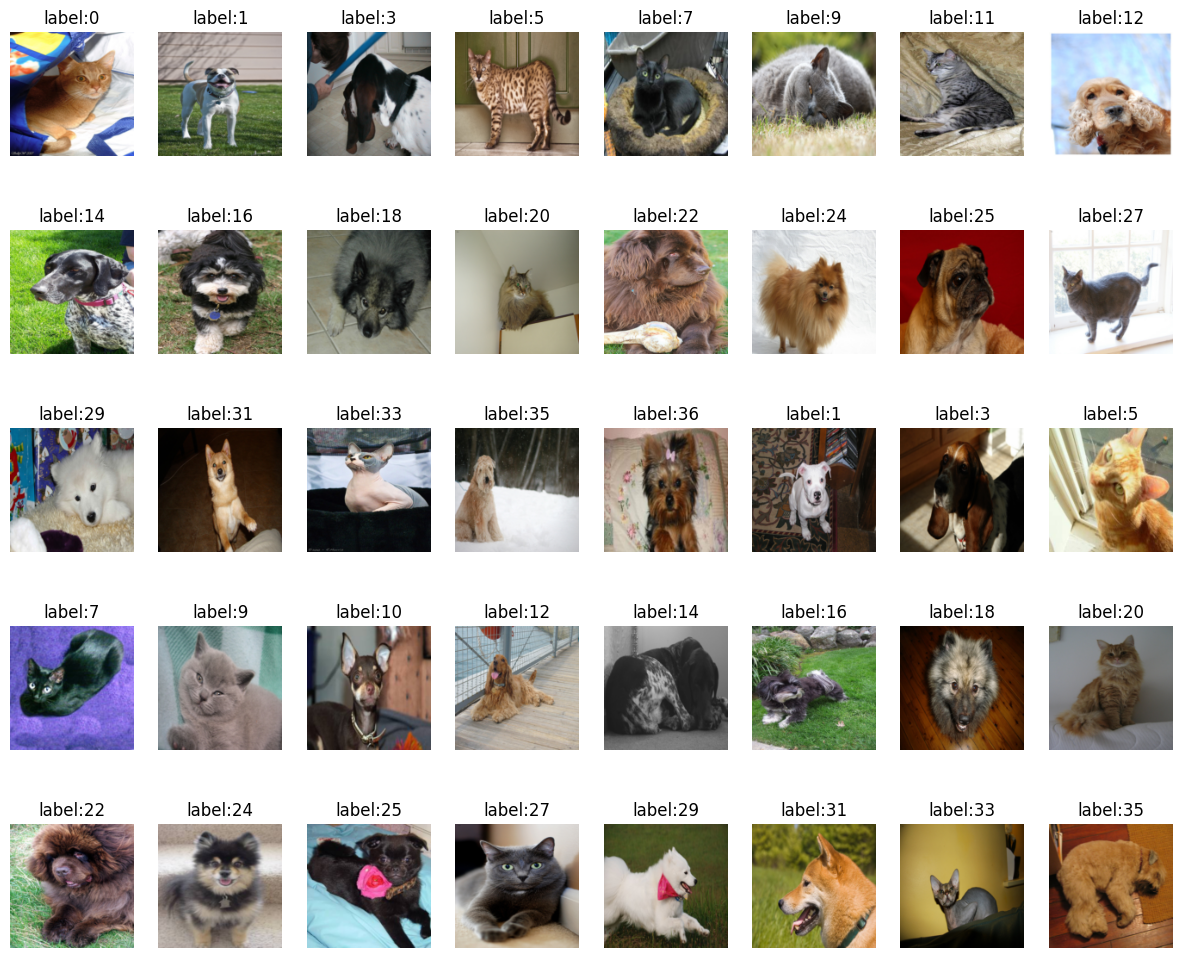

In [67]:
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image
import numpy as np

to_tensor = [Resize((144, 144)), ToTensor()]

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
        return image, target

def show_images(images, num_samples=40, cols=8):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    idx = int(len(images) / num_samples)
    for i, img in enumerate(images):
        if i % idx == 0:
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
            plt.imshow(to_pil_image(img[0]))
            plt.axis('off')
            plt.title(f'label:{img[1]}')

# 200 images for each pet
OxfordIIITPet_dataset = OxfordIIITPet(root=".", download=True, transforms=Compose(to_tensor))
show_images(OxfordIIITPet_dataset)

In [68]:
# Change target size to out_dim
out_dim=5 # pour le test
nb_targets = len(OxfordIIITPet_dataset.classes)
print('nombre de classes du dataset :',nb_targets)
#create a new dataset with the new target size
def generate_unique_vectors(nb_targets,output_dim=out_dim):
    '''
    Génère N vecteurs uniques de taille 5, chacun contenant des valeurs croissantes entre 100 et 6000.
    '''
    unique_vectors = []
    for i in range(nb_targets):
        # Générer un vecteur de taille 10 avec des valeurs aléatoires croissantes entre 100 et 6000
        vector = np.random.randint(100, 6000, size=output_dim)
        vector.sort()
        unique_vectors.append(vector)
    return unique_vectors

def label_to_vector(label, unique_vectors):
    '''
    input: label (int) : un ensemble de labels
           unique_vectors (list) : une liste de nb_targets vecteurs uniques
    output: new_label (array) : un ensemble de vecteurs de taille output_dim
    '''
    new_label = []
    for l in label:
        new_label.append(unique_vectors[l])
        #print('old label:',l,'new label:',unique_vectors[l])
    return new_label


unique_vectors = generate_unique_vectors(nb_targets)
#print(unique_vectors[:10])
dataset=OxfordIIITPet_dataset
# create variables for the img and labels
targets=OxfordIIITPet_dataset._labels
dataset._labels=label_to_vector(targets,unique_vectors)
print('taille targets:',len(targets))
print('taille nouveaux labels:',dataset._labels[0].shape)

nombre de classes du dataset : 37
taille targets: 3680
taille nouveaux labels: (5,)


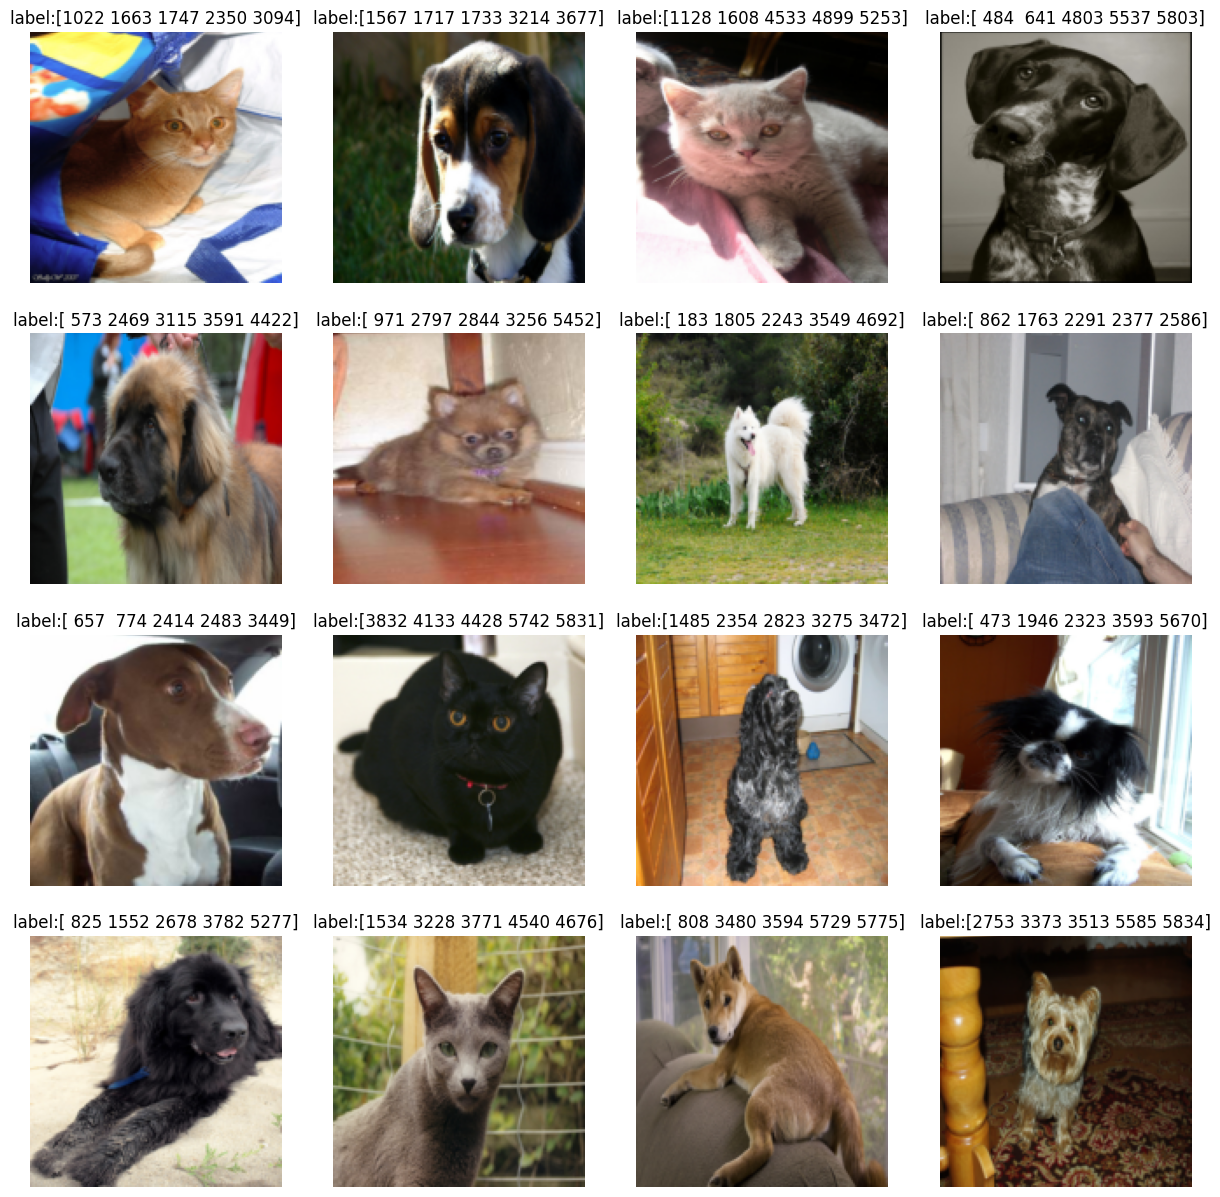

In [69]:
show_images(dataset,num_samples=15,cols=4)

### Séparation de l'image en patchs

Le patching dans le Vision Transformer est une technique utilisée pour traiter les images en les divisant en petites régions rectangulaires appelées "patches". Chaque patch est ensuite linéarisé pour être transformé en un vecteur de caractéristiques, qui peut être traité par un modèle transformer.

Dans notre code, la classe PatchEmbedding réalise cette opération de patching. Elle prend en entrée une image (ou un lot d'images) et divise chaque image en patchs de taille spécifiée (patch_size). Ensuite, ces patchs sont aplatis en vecteurs et transformés en un espace de caractéristiques de taille spécifiée (emb_size) à l'aide d'une couche linéaire.

Voici une explication plus détaillée du fonctionnement du code ci-dessous:

1- **Initialisation** : La classe PatchEmbedding est initialisée avec les paramètres nécessaires tels que le nombre de canaux d'entrée (in_channels), la taille des patchs (patch_size) et la taille de l'espace de caractéristiques (emb_size).

2- **Projection** : L'opération de projection est définie dans la méthode forward. Tout d'abord, l'image d'entrée est divisée en patchs à l'aide de la fonction Rearrange. Ensuite, chaque patch est aplatie en un vecteur et transformé en un nouvel espace de caractéristiques à l'aide d'une couche linéaire.

3- **Exécution** : Enfin, pour tester l'opération de patching, un échantillon de données est passé à travers la couche PatchEmbedding. Les formes des données d'entrée et de sortie sont imprimées pour illustrer la transformation effectuée pour nous assurer que tout fonctionne correctement.

En résumé, le patching est une étape cruciale dans le traitement des images par un Vision Transformer, car il permet de transformer une image en une séquence de vecteurs de caractéristiques, qui peuvent ensuite être traitées par un modèle.

In [70]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 8, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

# Run a quick test
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
print('number of color channels:', sample_datapoint.shape[1])
print('image size:', sample_datapoint.shape[2],',',sample_datapoint.shape[3])
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)
print('number of patches:', embedding.shape[1])
print('size of patches:', embedding.shape[2])

Initial shape:  torch.Size([1, 3, 144, 144])
number of color channels: 3
image size: 144 , 144
Patches shape:  torch.Size([1, 324, 128])
number of patches: 324
size of patches: 128


## Modèle

L'attention dans un transformer fonctionne en calculant le poids d'**importance de chaque élément de la séquence par rapport à tous les autres éléments de la même séquence**. Voici comment cela fonctionne brièvement :

1- **Calcul des requêtes (Query:Q), clés (Keys:K) et valeurs (Values:V)** : Dans un premier temps, les entrées sont transformées en trois vecteurs différents : Q,K et V. Ces transformations linéaires sont réalisées par les couches linéaires q, k et v respectivement dans le code.

2- **Calcul des scores d'attention** : Ensuite, les produits scalaires entre les requêtes et les clés sont calculés, puis divisés par la racine carrée de la dimension des vecteurs de requête et de clé. Ces scores représentent l'importance de chaque élément par rapport aux autres. Alors, ces scores sont passés à travers une fonction softmax pour obtenir des poids d'attention normalisés.

3- **Application des poids d'attention aux valeurs** : Les poids d'attention sont appliqués aux valeurs pour obtenir une combinaison pondérée des valeurs, représentant l'importance de chaque valeur pour chaque élément de la séquence.

4- **Sortie de l'attention** : Enfin, la sortie de l'attention est généralement combinée avec l'entrée initiale à l'aide de mécanismes de résidus et de normalisation.

Dans le code ci-dessous, la classe Attention encapsule cette opération d'attention. Elle prend en entrée la dimension des vecteurs (dim), le nombre de têtes d'attention (n_heads) et le taux de dropout (dropout). Elle utilise ensuite une couche d'attention multi-têtes (MultiheadAttention) de PyTorch pour calculer les poids d'attention et appliquer l'opération d'attention sur les données d'entrée. Les requêtes, clés et valeurs sont calculées à l'aide de couches linéaires (q, k et v), puis passées à travers la couche d'attention multi-têtes. Enfin, la sortie de l'attention est renvoyée en sortie de la fonction forward.

À noter que **le nombre de têtes dans un mécanisme d'attention multi-têtes** fait référence au nombre de fois que l'opération d'attention est effectuée simultanément, mais avec des projections différentes des données d'entrée. Chaque tête d'attention peut se concentrer sur des aspects différents des données d'entrée, permettant ainsi au modèle d'apprendre des représentations plus riches et plus complexes.


In [71]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

**Exemple**: 
Dans le code qui suit, l'output de la fonction Attention avec les paramètres dim=128, n_heads=4, et dropout=0. appliquée à un tenseur d'entrée de forme (1, 5, 128) est de taille (1, 5, 128).

Cela signifie que le tenseur de sortie a la même forme que le tenseur d'entrée. Dans ce cas spécifique :

- La première dimension (1) représente la **taille du batch**, indiquant qu'il y a un seul exemple dans le batch.
- La deuxième dimension (5) représente la **longueur de la séquence**, indiquant qu'il y a cinq vecteurs de caractéristiques (ou "**tokens**") dans la séquence. 
- La troisième dimension (128) représente la **taille des vecteurs de caractéristiques**, indiquant que chaque vecteur de caractéristiques dans la séquence est de taille 128.

Ainsi, chaque vecteur de caractéristiques de chaque élément de la séquence d'entrée a été transformé par le mécanisme d'attention, mais leur forme et leur taille n'ont pas été modifiées.

In [72]:
Attention(dim=128, n_heads=4, dropout=0.)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

La classe PreNorm réalise une opération de normalisation suivie d'une opération spécifique (définie par la fonction fn). Cela permet de stabiliser l'apprentissage en normalisant les entrées avant de les passer à une couche spécifique, comme dans les réseaux de transformer.

In [73]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

Par exemple, ici nous pouvons prénormaliser avant l'application du mécanisme d'attention. 

In [74]:
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

La classe FeedForward encapsule une opération de transformation non linéaire appliquée à chaque élément de la séquence. Cette opération est généralement composée de deux couches linéaires avec une fonction d'activation non linéaire entre elles (ici GELU). Cela permet au modèle d'apprendre des représentations plus complexes et non linéaires des données d'entrée.

Ces couches entièrement connectées servent à faire le lien entre les vecteurs de poids d'attention en inputs et qui les transforme pour les prochaines couches du modèle en output.

Encore une fois, pour notre exemple, nous avons une entrée de forme (1, 5, 128) et une sortie de forme (1, 5, 128). (nombre de séquences, nombre de tokens par séquence, taille des tokens)


In [75]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(), # activation function
            nn.Dropout(dropout),# apply dropout to avoid overfitting
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

Les **connexions résiduelles** sont utilisées pour faciliter l'apprentissage en permettant au gradient de se propager plus facilement à travers le réseau, en particulier pour les architectures profondes (On cherche à éviter la disparition du gradient, problème classique en Deep Learning).

La classe ResidualAdd ci-dessous implémente une connexion résiduelle. Voici comment elle fonctionne :

- L'entrée x est d'abord copiée dans la variable res pour **conserver la valeur originale**.
- Ensuite, x passe par une fonction fn, qui représente **une certaine opération**, telle qu'une couche de transformation ou un bloc de transformation.
- Après cela, **la sortie de la fonction fn est ajoutée à la valeur originale** res. Cela crée une connexion qui contourne la fonction fn, permettant à l'information d'entrée de passer directement à travers le bloc sans être altérée.
- Enfin, la **sortie mise à jour est renvoyée**.

En conclusion, les connexions résiduelles dans les ViT permettent de maintenir une information précieuse à travers les différentes couches du réseau.

In [76]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

On constate encore une fois que cela ne change pas les dimensions de l'input.

In [77]:
residual_att = ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.))
residual_att(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

Nous appliquons toutes les fonctions définies ci-dessus pour créer un modèle Vision Transformer complet. Le modèle Vision Transformer est composé des éléments suivants :
- **PatchEmbedding** : Une couche qui divise l'image en patchs et les transforme en vecteurs de caractéristiques (utilise la fonction PatchEmbedding définie ci-dessus).
- **TransformerEncoder** : Une série de couches de transformer qui effectuent des opérations d'attention et de transformation non linéaire sur les données d'entrée.(utilise les fonctions Attention, PreNorm, FeedForward et ResidualAdd définies ci-dessus).
- **ClassificationHead** : Une couche de classification qui prend la sortie du transformer et prédit les étiquettes de classe.

De plus la passe avant est également définie dans la fonction forward, c'est à dire comment le modèle va effectuer une prédiction à partir des données en input.


In [78]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=3, img_size=144, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=out_dim, dropout=0.1, heads=4):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Regression head
        self.head = nn.Sequential(
        nn.LayerNorm(emb_dim),  # Normalisation des caractéristiques en entrée
        nn.Linear(emb_dim, out_dim)
        )
        # out_dim = taille du vecteur de sortie



    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on regression token
        return self.head(x[:,0,:])


model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))


ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=32, out_featu

tensor([[ 0.6377, -0.1239, -0.6649, -0.6115, -0.0134]],
       grad_fn=<AddmmBackward0>)

## Entraînement

La première étape pour l'entrainement est de charger les données. Pour cela, nous utilisons le jeu de données chargé plus haut, qui contient des images et les labels correspondants. De plus nous séparons les données en un ensemble d'entraînement et un ensemble de test, qui nous serviront respectivement pour l'entraînement et l'évaluation du modèle. De plus, pour ne pas faire les évaluations intermédiaires sur le set de test, nous créons également un sous-ensemble de validation à partir du set d'entraînement.

In [79]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Split the dataset into train and test
train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])
print('Nombre de données dans l\'ensemble de train:',len(train))
print('Nombre de données dans l\'ensemble de test:',len(test))
# Split train set into train and validation
train_split2 = int(0.8 * len(train))
train, val = random_split(train, [train_split2, len(train) - train_split2])


train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

Nombre de données dans l'ensemble de train: 2944
Nombre de données dans l'ensemble de test: 736


Enfin, nous définissons la boucle d'entraînement. Nous devons décider de la valeurs de certains hyperparamètres qui peuvent fortement impacter la durée et la qualité de l'apprentissage, comme:
- le nombre d'époques (nombre de fois que le modèle voit l'ensemble d'entraînement)
- le taux d'apprentissage (vitesse à laquelle le modèle apprend)
- la taille du batch (nombre d'exemples utilisés pour calculer le gradient, à chaque itération)
- la fonction de perte (métrique utilisée pour évaluer la performance du modèle)
- l'optimiseur (algorithme utilisé pour mettre à jour les poids du modèle)

In [80]:
import torch.optim as optim
import numpy as np

# use GPU if available, else use CPU
device = ("cuda" if torch.cuda.is_available() else "cpu")
model = ViT().to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.001) # Optimizer for training, and learning rate
criterion = nn.MSELoss() # Loss function for regression
train_losses = []
val_losses = []
epochs_count_train=[]
epochs_count_val=[]
# Training loop
for epoch in range(6): # Change this to train longer/shorter
    epoch_losses = []
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        #print('shape inputs',inputs.shape)
        #print('shape outputs:',outputs.shape,'shape labels:' ,labels.shape)
        #print('outputs:',outputs)
        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    # Print epoch loss, every 5 epochs
    if epoch % 5 == 0:
        print(f">>> Epoch {epoch} train loss: ", np.mean(epoch_losses))
        epoch_losses = []
        # Something was strange when using this?
        # model.eval()
        # Validation loop, every 5 epochs
        train_losses.append(np.mean(loss.item()));epochs_count_train.append(epoch)
        for step, (inputs, labels) in enumerate(val_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Save the losses for plotting
            val_losses.append(np.mean(loss.item()));epochs_count_val.append(epoch)
            epoch_losses.append(loss.item())
        print(f">>> Epoch {epoch} validation loss: ", np.mean(epoch_losses))

>>> Epoch 0 train loss:  11947846.14864865
>>> Epoch 0 validation loss:  11947826.315789474
>>> Epoch 5 train loss:  11735928.22972973
>>> Epoch 5 validation loss:  11715515.47368421


Nous pouvons visualiser les courbes d'entraînement, c'est à dire l'évolutions des pertes sur l'ensemble d'entraînement et de validation au cours des époques. Cela nous permet de voir comment le modèle apprend et s'il est en train de **converger vers une solution optimale ou non**. De plus, en comparant les pertes sur l'ensemble de validation et d'entraînement, nous pouvons détecter des problèmes de surapprentissage (**overfitting**) ou de sous-apprentissage (**underfitting**).

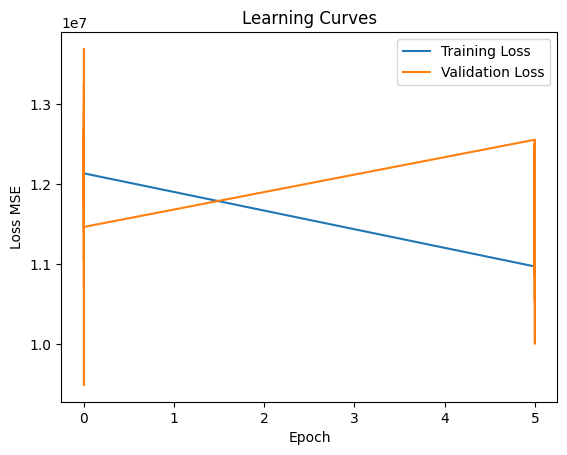

In [81]:
# Plot training and validation losses
plt.plot(epochs_count_train,train_losses, label='Training Loss')
plt.plot(epochs_count_val,val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss MSE')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Évaluation

Mainteanant que nous avons entraîné notre réseau de neurones, il est temps d'**évaluer ses performances sur l'ensemble de test**. Pour cela, nous allons utiliser la métrique de l'erreur quadratique moyenne (MSE), qui mesure la moyenne des carrés des différences entre les prédictions du modèle et les étiquettes réelles. Plus l'erreur quadratique moyenne est faible, meilleure est la performance du modèle.

Utiliser le set de test pour l'évaluation nous permet d'estimer à quel point notre modèle est généralisable, puisque qu'il n'a jamais vu ces données auparavant.

In [82]:
model.eval()  # Mettre le modèle en mode d'évaluation

# Listes pour stocker les prédictions et les étiquettes
all_images= []
all_predictions = []
all_labels = []

# Boucle d'évaluation sur l'ensemble de test
for inputs, labels in test_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)  # Transférer les données sur le périphérique
    all_images.append(inputs)
    with torch.no_grad():  # Pas de calcul de gradient pendant l'évaluation
        outputs = model(inputs)  # Faire des prédictions
        #print('input',inputs)
        #print('output:',outputs)
    all_predictions.append(outputs.detach().cpu().numpy())  # Détacher les prédictions et les transférer sur CPU
    all_labels.append(labels.cpu().numpy())  # Transférer les étiquettes sur CPU

# Concaténer les résultats de tous les lots
all_images = np.concatenate(all_images, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
#print('taille des prédictions:',len(all_predictions))
# Calculer la métrique (par exemple, l'erreur quadratique moyenne)
mse = np.mean((all_predictions - all_labels) ** 2)

# Afficher la métrique
print("Mean Squared Error on Test Set:", mse)


Mean Squared Error on Test Set: 12137426.851938467


Nous pouvons également **visualiser quelques une des prédictions** réalisées par notre modèle sur l'ensemble de test, et les comparer aux labels réels. Cela nous permet de voir comment le modèle se comporte sur des exemples individuels, et de vérifier s'il est capable de prédire correctement les étiquettes.

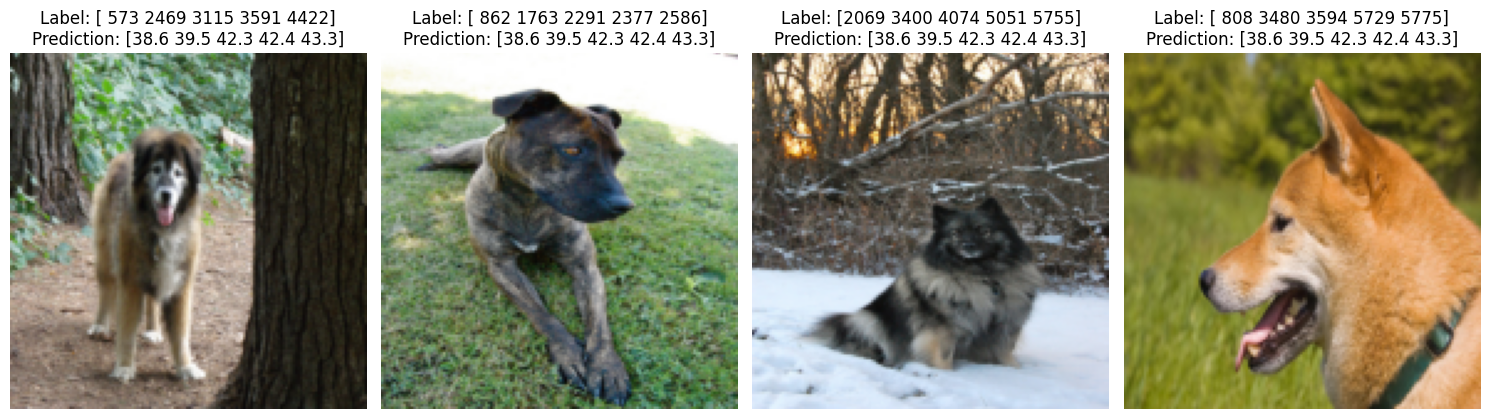

In [83]:
import random

# Définir une fonction pour afficher des images avec leurs étiquettes et prédictions
def visualize_predictions(images=all_images, labels=all_labels, predictions=all_predictions, num_images=4):
    # Sélectionner aléatoirement quelques indices d'images
    #print('nombre d\'images',len(all_images))
    indices = random.sample(range(len(all_predictions)), num_images)
    #print('indices choisis',indices)

    # Créer une grille pour afficher les images
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 7))

    # Afficher chaque image avec son étiquette et sa prédiction
    for i, idx in enumerate(indices):
        #print('i:',i)
        #print('idx:',idx)
        ax = axes[i]
        image = images[idx]
        label = labels[idx]
        prediction = np.round(predictions[idx],1)
        #print('prediction:',predictions)

        # Afficher l'image
        ax.imshow(np.transpose(image, (1, 2, 0)))  # Permutation des dimensions pour Matplotlib
        ax.set_title(f"Label: {label}\nPrediction: {prediction}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()



# Afficher quelques images avec leurs étiquettes et prédictions
visualize_predictions()


À noter qu'il va falloir s'entraîner plus longtemps.

In [84]:
# Save the model
torch.save(model.state_dict(), "vit_model.pth")